# Testing map generation

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas
import torch

# create a sample segmentation

In [34]:
N = 10
source = np.eye(N, N)
for i in range(N-1):
    source[i, i+1] = 1
    source[i+1, i] = 1
for i in range(N-2):
    source[i, i+2] = 0.5
    source[i+2, i] = 0.5
for i in range(N-3):
    source[i, i+3] = 0.5
    source[i+3, i] = 0.5

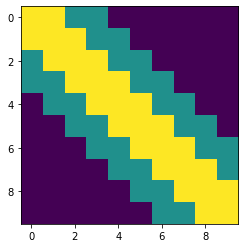

In [35]:
plt.imshow(source); plt.show()

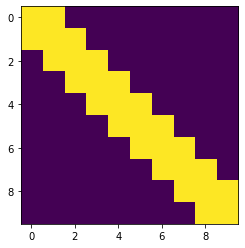

In [117]:
plt.imshow(source >0.5); plt.show() # the 'correct' segmentation lets say

In [313]:
# create a bunch of samples around that sample
A = np.random.randn(N, 2) * 0.2
Sigma = A @ A.T
M = 20 # number of samples, 
samples = (np.random.randn(M, N, N) @ Sigma  + 1.) * source

In [314]:
samples = torch.sigmoid(torch.Tensor(samples)).numpy()

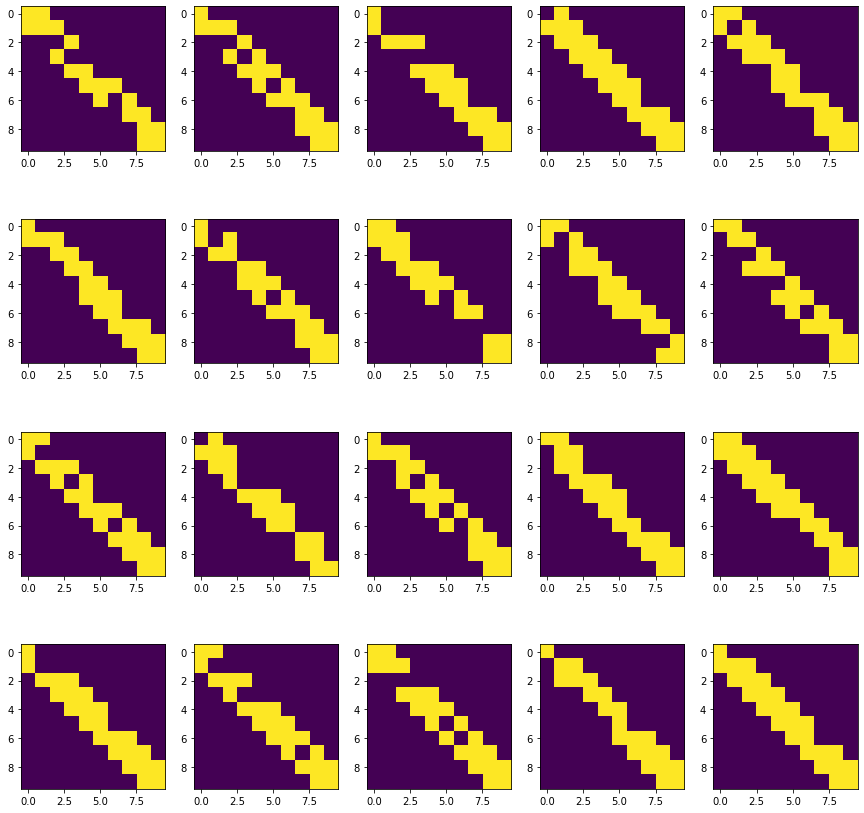

In [315]:
plt.figure(figsize=(15,15))
for i in range(M):
    plt.subplot(4, 5, i+1)
    plt.imshow(samples[i] > 0.7)

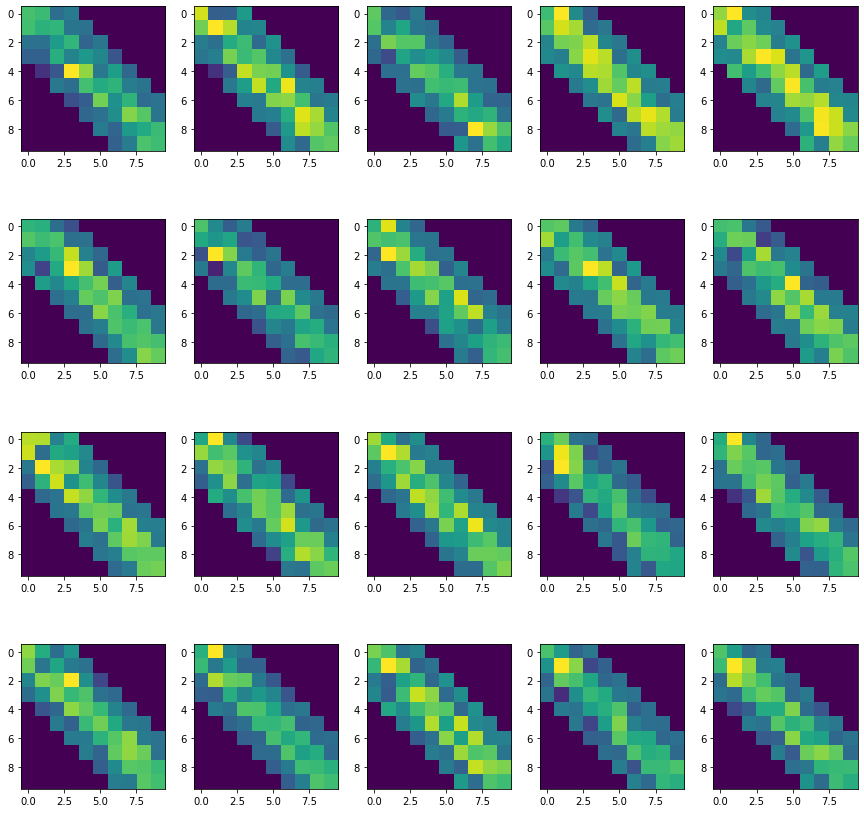

In [316]:
plt.figure(figsize=(15,15))
for i in range(M):
    plt.subplot(4, 5, i+1)
    plt.imshow(samples[i])

### Calculate the entropy to get the uncertainty map

In [321]:
np.histogram(samples, bins=3)

(array([1106,  678,  216]),
 array([0.5       , 0.6194991 , 0.73899823, 0.8584973 ], dtype=float32))

In [ ]:
a = torch.sigmoid(torch.Tensor(samples)).numpy()

In [ ]:
np.unique(np.around(samples, 1))

array([0.5, 0.6, 0.7, 0.8, 0.9], dtype=float32)

In [ ]:
1/100 * 10

0.1

In [ ]:
np.log(np.e)

1.0

In [ ]:
x = np.array([0.5,0.5,1,1,0,0])

In [ ]:
stats.entropy(torch.nn.functional.softmax(torch.Tensor(x)).numpy())

/tmp/ipykernel_46927/2231127340.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  stats.entropy(torch.nn.functional.softmax(torch.Tensor(x)).numpy())


1.7133384

In [ ]:
torch.nn.functional.softmax(torch.Tensor(x))

/tmp/ipykernel_46927/1453829845.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(torch.Tensor(x))


tensor([0.1536, 0.1536, 0.2532, 0.2532, 0.0932, 0.0932])

In [ ]:
entropy = 0
uniques = np.unique(x)
M = len(x)
for u in uniques:
    p_m_hat = np.sum([x==u]) / M
    if p_m_hat > 0:
        entropy += - p_m_hat * np.log(p_m_hat)

In [210]:
entropy

1.0986122886681096

In [212]:
# now get a multidim x
a = np.random.rand(10, 2, 3)
b = np.around(a, 1)

In [219]:
a

array([[[0.55531769, 0.13805114, 0.25549938],
        [0.0561759 , 0.00731672, 0.45178398]],

       [[0.00279715, 0.59796659, 0.58445441],
        [0.46871451, 0.79773061, 0.24853759]],

       [[0.34395622, 0.72338325, 0.86341887],
        [0.57340222, 0.53386627, 0.92217226]],

       [[0.48806265, 0.89845565, 0.04681799],
        [0.64253988, 0.66185732, 0.69922109]],

       [[0.61829301, 0.64333814, 0.72949305],
        [0.69476066, 0.42876458, 0.01869623]],

       [[0.44477895, 0.50436676, 0.7332365 ],
        [0.45403017, 0.72232518, 0.60765831]],

       [[0.22960859, 0.55751839, 0.12916058],
        [0.96509662, 0.18438372, 0.25301998]],

       [[0.32173377, 0.08893736, 0.99833292],
        [0.9435476 , 0.64680341, 0.43806637]],

       [[0.31361814, 0.07167432, 0.55005571],
        [0.48741824, 0.50379152, 0.67348642]],

       [[0.77782105, 0.6653582 , 0.34217409],
        [0.99423888, 0.27891074, 0.93592542]]])

In [259]:
x

array([0.5, 0.5, 1. , 1. , 0. , 0. ])

In [322]:
def samples_entropy_map(samples, 
                        p_from_mode=True,
                        threshold_preds=False,
                        preds_threshold=0.9,
                        apply_norm=False,
                        norm_func='sigmoid',
                        apply_binning=False,
                        binning_dp = 1,
                        supress_warning=False,
                        print_uniques=False,
                       ):
    """
    H(y|x) = - sum_1^M{p_hat_i_m ln(p_hat_i_m)}
    where p_hat_m is the frequency of the m-th unique value.
    
    Okay so this implies that my model results have been turned directly
    into classes which currently my model outputs are not
    
    so should I take the mode or the mean..?
    
    samples: the different samples taken for the input batch
    p_from_mode: the different smaples taken for the input batch
    """
    # i.e should be number of classes, but could also represent
    # probability of being class 1, so I need to decide what I am rrepresenting
    # the former makes this function easier and fits mroe nicely with the 'semantic segmentation idea'.
    # but ideally the model outputs a probability... hmm should clear this up with them.
    
    if threshold_preds:
        if not supress_warning:
            print("warning, thresholding only valid for binary class problem")
        samples = samples > preds_threshold
        
    if apply_binning:
        if not supress_warning:
            print("warning, binning should only be applied where output is a probability")
        samples = np.around(samples, binning_dp)
    
    return entropy(samples, supress_warning, print_uniques)
    

In [323]:
def entropy(samples, supress_warning=False, print_uniques=False):
    """
    calculates entropy where samples is in shape
    [s, b, x, y, (z)] s = samples, b = batch size, 
    note there should not be multiple channels
    """
    if not supress_warning:
        print("warning: multiclass problems should be presented as single channel, value = id of class")
    samples = np.array(samples)
    V = len(samples)
    samples = np.moveaxis(samples, 0, -1)
    # print(samples.shape)
    uniques = np.unique(samples)
    if print_uniques:
        print(uniques)
    entropy = np.zeros(samples.shape[:-1])
    for u in uniques:
        p_m_hat = np.sum([samples==u], axis=-1).squeeze() / V
        entropy += - p_m_hat * np.ma.log(p_m_hat)
    return entropy

In [324]:
e = samples_entropy_map(samples, apply_binning=True)

warning, binning should only be applied where output is a probability


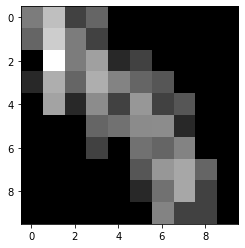

In [325]:
plt.imshow(e, cmap='gray')

In [326]:
mode_result = stats.mode(samples, axis=0)
mode_prediction = mode_result[0][0]

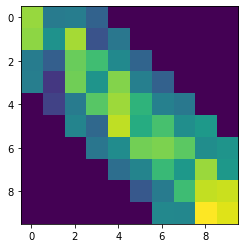

In [327]:
plt.imshow(mode_prediction)

In [305]:
def samples_variance_map(samples):
    """
    calculates entropy where samples is in shape
    [s, b, x, y, (z)] s = samples, b = batch size, 
    note there should not be multiple channels
    """
    return np.var(samples, axis=0)

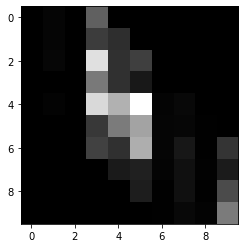

In [308]:
plt.imshow(samples_variance_map(samples), cmap='gray')